# Summary

Explore derivation of indicatrix and figuratrix. 

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    # pr_filenames = ['IndicatrixExploration_sinbeta_eta1p5']
    pr_filenames = ['IndicatrixExploration_sinbeta_eta0p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, \
    diff, pi, numer, denom,init_printing
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Scipy utils
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import *
from gme.core.equations import Equations
from gme.plot.indicatrix_new import IndicatrixNew
from gme.plot.triangle_inequality import TriangleInequality
# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme)
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['IndicatrixExploration_sinbeta_eta0p5'])

### Parameter parsing

In [4]:
parameters_dict,_ = import_parameters(pr_path, [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/Theory/IndicatrixExploration_sinbeta_eta0p5.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'indicatrix_exploration',
    'subtitle': '',
    'title': 'Exploration of indicatrix etc for sin(beta) erosion model, '
             'eta=1/2',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
 

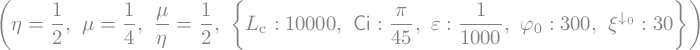

In [5]:
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
        Ci: pr.model.Ci, 
        Lc: pr.model.Lc, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
#         kappa_h: pr.model.kappa_h,
#         h_0: pr.model.h_0,
#         x_sigma: pr.model.x_sigma,
#         x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Theory

### Basics

In [6]:
gmeq = Equations( eta_=pr.model.eta, 
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
#                   ibc_type=pr.model.ibc_type,
                  parameters=sub, 
                  do_raw=False )

gme.core.equations.Equations
gme.core.equations.EquationsMixedIn
gme.core.equations.EquationsBase
gme.core.rp.define_p_eqns
gme.core.rp.define_r_eqns
gme.core.xi.define_xi_eqns
gme.core.xi.define_xi_model_eqn
gme.core.xi.define_xi_related_eqns
gme.core.varphi.define_varphi_model_eqns
gme.core.varphi.define_varphi_related_eqns
gme.core.fundamental.define_Fstar_eqns
gme.core.fundamental.define_H_eqns
gme.core.hamiltons.define_rdot_eqns
gme.core.hamiltons.define_pdot_eqns
gme.core.hamiltons.define_Hamiltons_eqns
gme.core.ndim.nondimensionalize
gme.core.ndim.define_nodimensionalized_Hamiltons_eqns
gme.core.profile.define_z_eqns
gme.core.angles.define_tanalpha_eqns
gme.core.angles.define_tanbeta_eqns
gme.core.angles.define_psi_eqns
gme.core.metrictensor.define_g_eqns
gme.core.pxpoly.define_px_poly_eqn (ndim=False)
gme.core.pxpoly.define_px_poly_eqn (ndim=True)


In [7]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta'])
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(N(gmeq.eta_))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix.replace('.','p')
job_name

'indicatrix_exploration_sinbeta_eta0p5'

### Lagrangian & related

In [ ]:
import sympy as sy
s = sy.symbols(r's',  real=True)
vx = sy.symbols(r'x',  real=True)
vz = sy.symbols(r'z',  real=True)
v = sy.symbols(r'v',  real=True, positive=True)

Grab closed-form Lagrangian for $\eta=1/2$ and $\alpha<\alpha_{\mathrm{ext}}$.

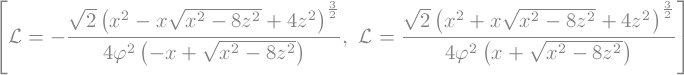

In [ ]:
L_compact_eqn = Eq(L, 
    -s*(sqrt(2)*(vx**2-s*vx*sqrt(vx**2-8*vz**2)+4*vz**2)**Rational(3,2)
        /(4*varphi**2*(-s*vx+sqrt(vx**2-8*vz**2)))) 
)
L_compact_eqns = [
    L_compact_eqn.subs({s:s_}) for s_ in (+1,-1)
]
F_compact_eqns = [
    Eq(F, (sqrt(L*2)).subs(e2d(L_compact_eqn_)))
    for L_compact_eqn_ in L_compact_eqns
]
del L_compact_eqn
L_compact_eqns

In [ ]:
if gmeq.eta_==Rational(1,2):
    vx_,vz_ = 0.9,-0.2978
    px_,pz_ = 0.6630963505914919,-1.354973165538337
else:
    vx_,vz_ = 1.05462010732076, 0.214847320357639
    px_,pz_ = 1.15,-1.
varphi_ = 1

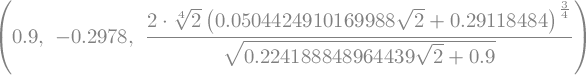

In [ ]:
vx_,vz_, F_compact_eqns[1].rhs.subs({varphi:1, vx:vx_, vz:vz_})

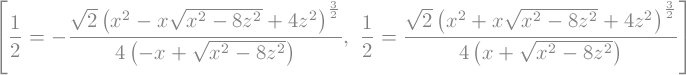

In [ ]:
vx_vz_implicit_eqns = [
    L_compact_eqn_.subs({L:Rational(1,2), varphi:1})
    for L_compact_eqn_ in L_compact_eqns
]
vx_vz_implicit_eqns

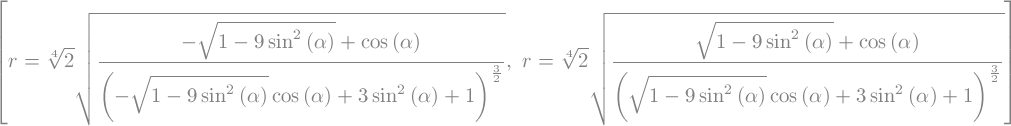

In [ ]:
v_alpha_eqns = [
        Eq( r,
        s_*solve((sy.trigsimp(vx_vz_implicit_eqn_.subs({vx:v*cos(alpha),vz:-v*sin(alpha)}))
        .subs({cos(alpha)**2:1-sin(alpha)**2})), v)[0]
    )
    for (vx_vz_implicit_eqn_,s_) in zip(vx_vz_implicit_eqns, (+1,-1))
]
v_alpha_eqns

In [ ]:
[
    ( v_alpha_eqn_.rhs.subs({alpha:sy.rad(0.1)}).n() )
    for v_alpha_eqn_ in v_alpha_eqns
]

In [ ]:
v_alpha_lambdifieds = [
    lambdify((alpha), v_alpha_eqn_)
    for v_alpha_eqn_ in v_alpha_eqns
]
v_alpha_lambdas = [
    lambda alpha_: v_alpha_lambdified_(alpha_)
    for v_alpha_lambdified_ in v_alpha_lambdifieds
]

# Plots

### Indicatrix & figuratrix – rectilinear axes

In [69]:
gri = IndicatrixNew(gmeq, pr, subexp, varphi_=1)

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear size=(7, 9) @ 100 dpi


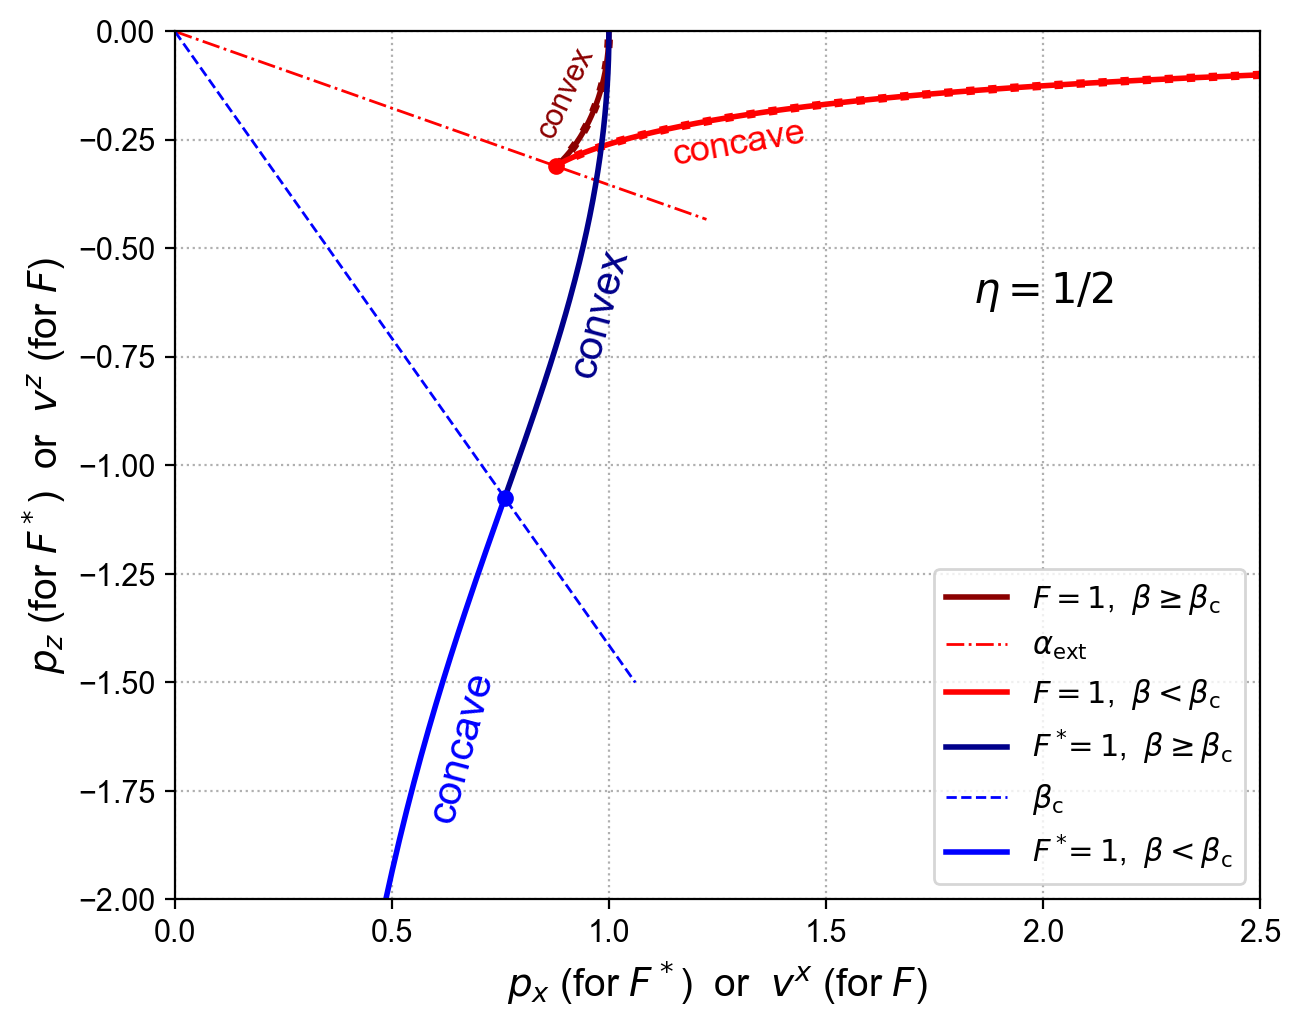

In [70]:
gri.Fstar_F_rectlinear(gmeq, job_name, pr, v_eqns=v_alpha_eqns, fig_size=(7,9))

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom size=(7, 7) @ 100 dpi


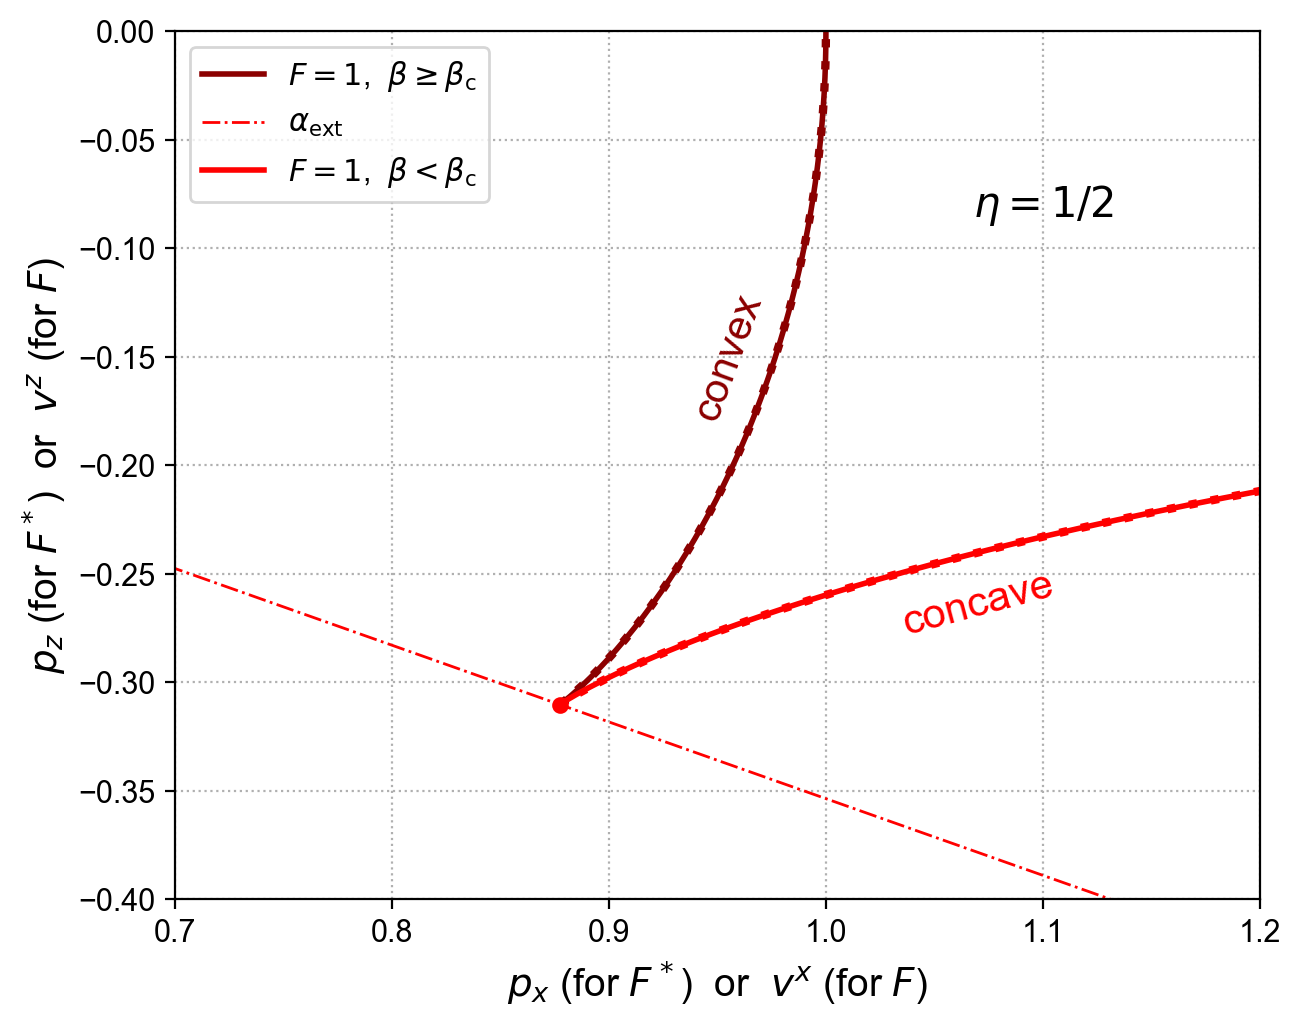

In [71]:
gri.Fstar_F_rectlinear(gmeq, job_name, pr, v_eqns=v_alpha_eqns, fig_size=(7,7), do_zoom=True)

### Indicatrix & figuratrix – log-polar axes

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar size=[6, 6] @ 100 dpi


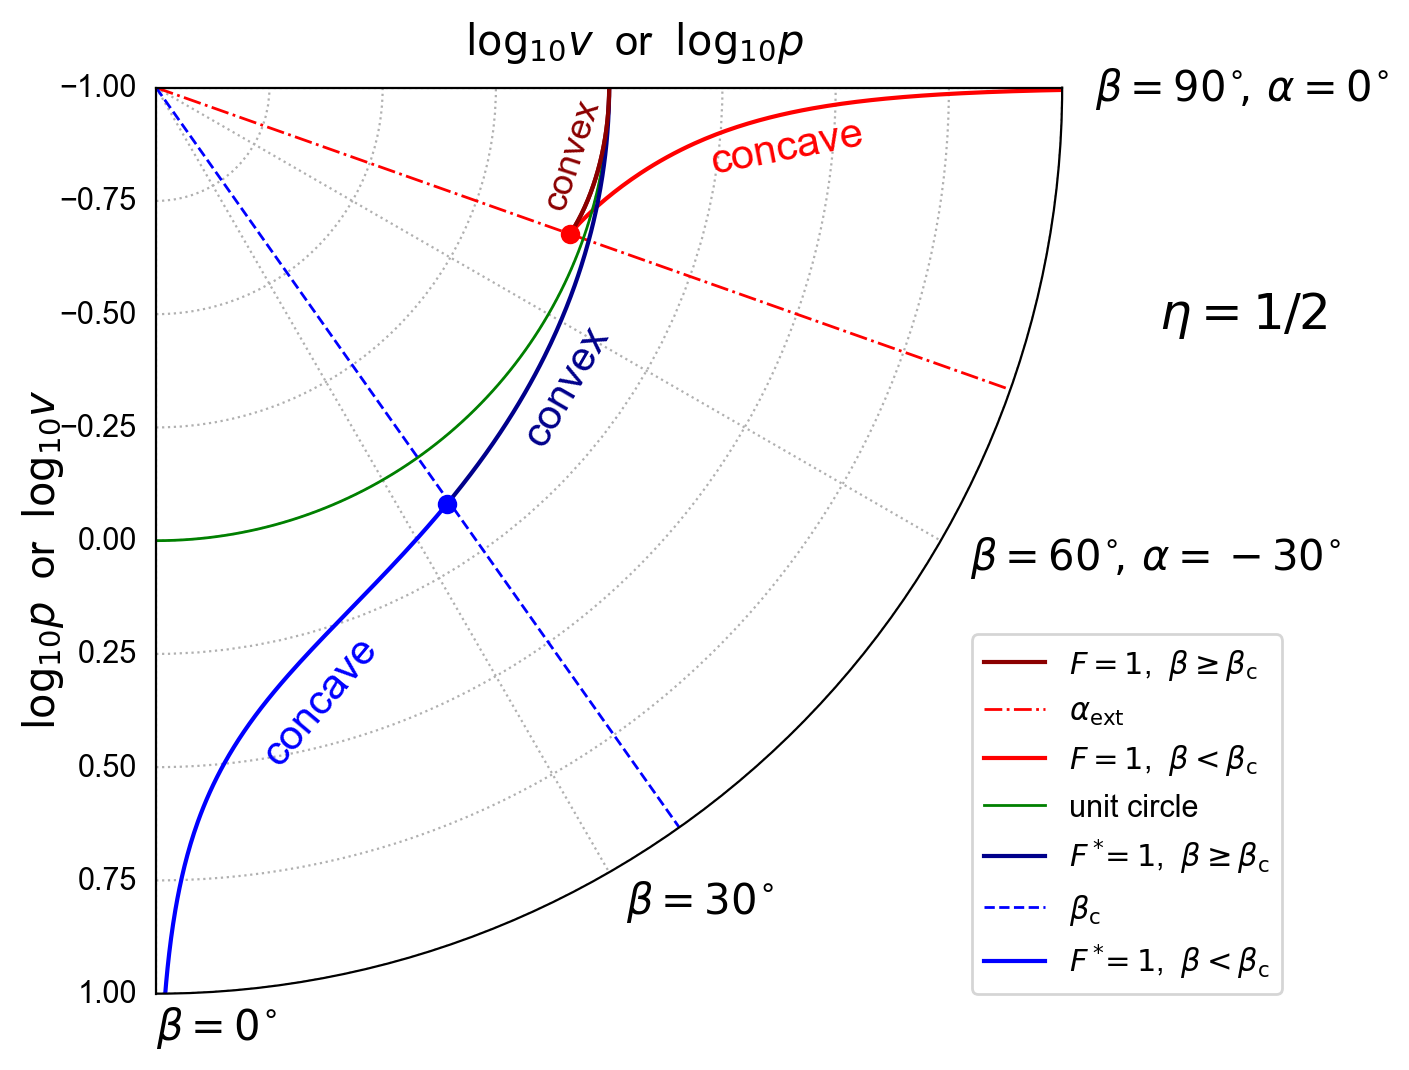

In [72]:
gri.Fstar_F_polar(gmeq, job_name, pr, fig_size=[6,6])

### Triangle inequality test

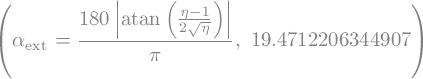

In [321]:
alpha_ext_eqn = Eq( alpha_ext, sy.Abs(sy.deg(atan( (eta-1)/(2*sqrt(eta))) )) )
gmeq.alpha_ext_eqn = alpha_ext_eqn
alpha_ext_eqn, float(gmeq.alpha_ext_eqn.rhs.subs({eta: gmeq.eta_}).n())

In [208]:
v_alpha_eqn_ = v_alpha_eqns[0]

In [550]:
alpha_ext_ = -np.deg2rad(
    float(gmeq.alpha_ext_eqn.rhs.subs({eta: gmeq.eta_}).n())
)
alpha0_array = -np.deg2rad(np.array([5, 10, 15]))
f_alpha0_array = alpha0_array / alpha_ext_

# n_alpha1_ = 3
# n_alpha1_ = 22
n_alpha1_ = 42
n_alpha1_ = 42+40
n_delta1_ = n_alpha1_ - 1

ndelta_t12_grids = {}
alpha1_arrays = {}
ndelta_t1_arrays = {}

do_check = False

# Select the reference ray angle
# Note: all alpha0 values are negative
for alpha0_ in alpha0_array[:]:
    print(f"alpha0 = {np.rad2deg(alpha0_):.2f}º", flush=True)
    # Get the velocity in this direction
    v0_ = float(v_alpha_eqn_.rhs.subs({alpha: alpha0_}).n())
    # Specify unit distance along the reference ray
    r0_ = 1
    # Calculate time elapsed to cover this unit distance
    delta_t0_ = r0_ / v0_
    # Compute the reference ray vector components
    rx0_ = r0_ * np.cos(alpha0_)
    rz0_ = r0_ * np.sin(alpha0_)

    # Select the first subray angle
    # Note: alpha_ext is negative, so all the alpha1 values are negative
    raw_alpha1_array_ = np.linspace(-0, -20, n_alpha1_ - 1)
    raw_alpha1_array_ = raw_alpha1_array_[
        raw_alpha1_array_ > np.rad2deg(alpha_ext_)
    ]
    raw_alpha1_array_ = np.concatenate(
        [raw_alpha1_array_, np.array([np.rad2deg(alpha_ext_)])]
    )
    alpha1_arrays[alpha0_] = np.deg2rad(raw_alpha1_array_)
    print(raw_alpha1_array_)

    ndelta_t1_arrays[alpha0_] = np.linspace(0, 2, n_delta1_)
    ndelta_t12_grids[alpha0_] = np.zeros(
        (
            np.shape(alpha1_arrays[alpha0_])[0],
            np.shape(ndelta_t1_arrays[alpha0_])[0],
        )
    )

    for i_alpha1_, alpha1_ in enumerate(alpha1_arrays[alpha0_]):
        # alpha1_ = alpha0_
        if n_alpha1_ <= 5:
            print(f"\talpha1 = {np.rad2deg(alpha1_):.2f}º", flush=True)
        # Select the time elapsed along the first subray
        for i_delta1_, ndelta_t1_ in enumerate(ndelta_t1_arrays[alpha0_]):
            delta_t1_ = delta_t0_ * ndelta_t1_
            if n_alpha1_ <= 5:
                print(f"\tndelta_t1_ = {ndelta_t1_:.3f}", flush=True)
            # Get the velocity in this direction
            v1_raw_ = v_alpha_eqn_.rhs.subs({alpha: alpha1_}).n()
            if im(v1_raw_) == 0:
                v1_ = float(v1_raw_)
            else:
                v1_ = np.nan
            # Calculate the distance covered along this subray
            # given the specified time
            r1_ = v1_ * delta_t1_
            # Compute the vector components of this subray
            rx1_ = r1_ * np.cos(alpha1_)
            rz1_ = r1_ * np.sin(alpha1_)

            # Compute second subray vector needed to match the reference ray
            rx2_ = rx0_ - rx1_
            rz2_ = rz0_ - rz1_
            r2_ = np.sqrt(rx2_ ** 2 + rz2_ ** 2)
            alpha2_ = np.arctan(rz2_ / rx2_)
            # Get the velocity in this direction
            v2_raw_ = v_alpha_eqn_.rhs.subs({alpha: alpha2_}).n()
            if (
                im(v2_raw_) == 0
                and alpha2_ > alpha_ext_
                and alpha2_ < 0
                and (rx2_ > 0 and rz2_ < 0)
                and not np.isnan(v1_)
            ):
                v2_ = float(v2_raw_)
                # Calculate the travel time to cover this subray distance
                # given the speed
                # if rz2_ > 0:
                #     print("r2: ", rx2_, rz2_, alpha2_)
                delta_t2_ = r2_ / v2_
                if do_check:
                    r12_check_ = delta_t1_ * np.array(
                        [v1_ * np.cos(alpha1_), v1_ * np.sin(alpha1_)]
                    ) + delta_t2_ * np.array(
                        [v2_ * np.cos(alpha2_), v2_ * np.sin(alpha2_)]
                    )
                    r0_check_ = delta_t0_ * np.array(
                        [v0_ * np.cos(alpha0_), v0_ * np.sin(alpha0_)]
                    )
                    if (
                        np.round(r12_check_, 5)[0] != np.round(r0_check_, 5)[0]
                        or np.round(r12_check_, 5)[1]
                        != np.round(r0_check_, 5)[1]
                    ):
                        if n_alpha1_ <= 5:
                            print("r0 & r12 mismatch")
                            print(v1_, v2_)
                            print(rx0_, rx1_, rx2_, rx1_ + rx2_)
                            print(rz0_, rz1_, rz2_, rz1_ + rz2_)
                        v2_ = 0
                        delta_t2_ = np.nan
            else:
                v2_ = 0
                delta_t2_ = np.nan

            # Calculate the travel time along the subray path
            delta_t12_ = delta_t1_ + delta_t2_

            # Record
            ndelta_t12_grids[alpha0_][i_alpha1_, i_delta1_] = (
                delta_t12_ / delta_t0_
            )
            if n_alpha1_ <= 5 and alpha0_ == alpha1_:
                print(
                    "\talphas:",
                    np.round(
                        np.rad2deg(
                            np.array(
                                [
                                    alpha0_,
                                    alpha1_,
                                    alpha2_,
                                ]
                            )
                        ),
                        3,
                    ),
                    "\tdelta_ts:",
                    np.round(
                        np.array(
                            [
                                # delta_t0_,
                                delta_t1_ / delta_t0_,
                                delta_t2_ / delta_t0_,
                                delta_t12_ / delta_t0_,
                            ]
                        ),
                        3,
                    ),
                )
                # print(
                #     "\t",
                #     np.round(np.rad2deg(alpha1_), 3),
                #     np.round(delta_t1_, 3),
                #     np.round(delta_t12_ / delta_t0_, 3),
                # )


alpha0 = -5.00º
[  0.          -0.25        -0.5         -0.75        -1.
  -1.25        -1.5         -1.75        -2.          -2.25
  -2.5         -2.75        -3.          -3.25        -3.5
  -3.75        -4.          -4.25        -4.5         -4.75
  -5.          -5.25        -5.5         -5.75        -6.
  -6.25        -6.5         -6.75        -7.          -7.25
  -7.5         -7.75        -8.          -8.25        -8.5
  -8.75        -9.          -9.25        -9.5         -9.75
 -10.         -10.25       -10.5        -10.75       -11.
 -11.25       -11.5        -11.75       -12.         -12.25
 -12.5        -12.75       -13.         -13.25       -13.5
 -13.75       -14.         -14.25       -14.5        -14.75
 -15.         -15.25       -15.5        -15.75       -16.
 -16.25       -16.5        -16.75       -17.         -17.25
 -17.5        -17.75       -18.         -18.25       -18.5
 -18.75       -19.         -19.25       -19.47122063]
alpha0 = -10.00º
[  0.          -0.25     

In [551]:
grt = TriangleInequality(gmeq)

gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_falpha0p31 size=(6, 6) @ 100 dpi
gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_falpha0p56 size=(6, 6) @ 100 dpi
gmplib.plot.GraphingBase:
   Creating plot: indicatrix_exploration_sinbeta_eta0p5_falpha0p82 size=(6, 6) @ 100 dpi


0.5 1.0200000000000007
0.7 1.0200000000000002
0.9 1.0200000000000002


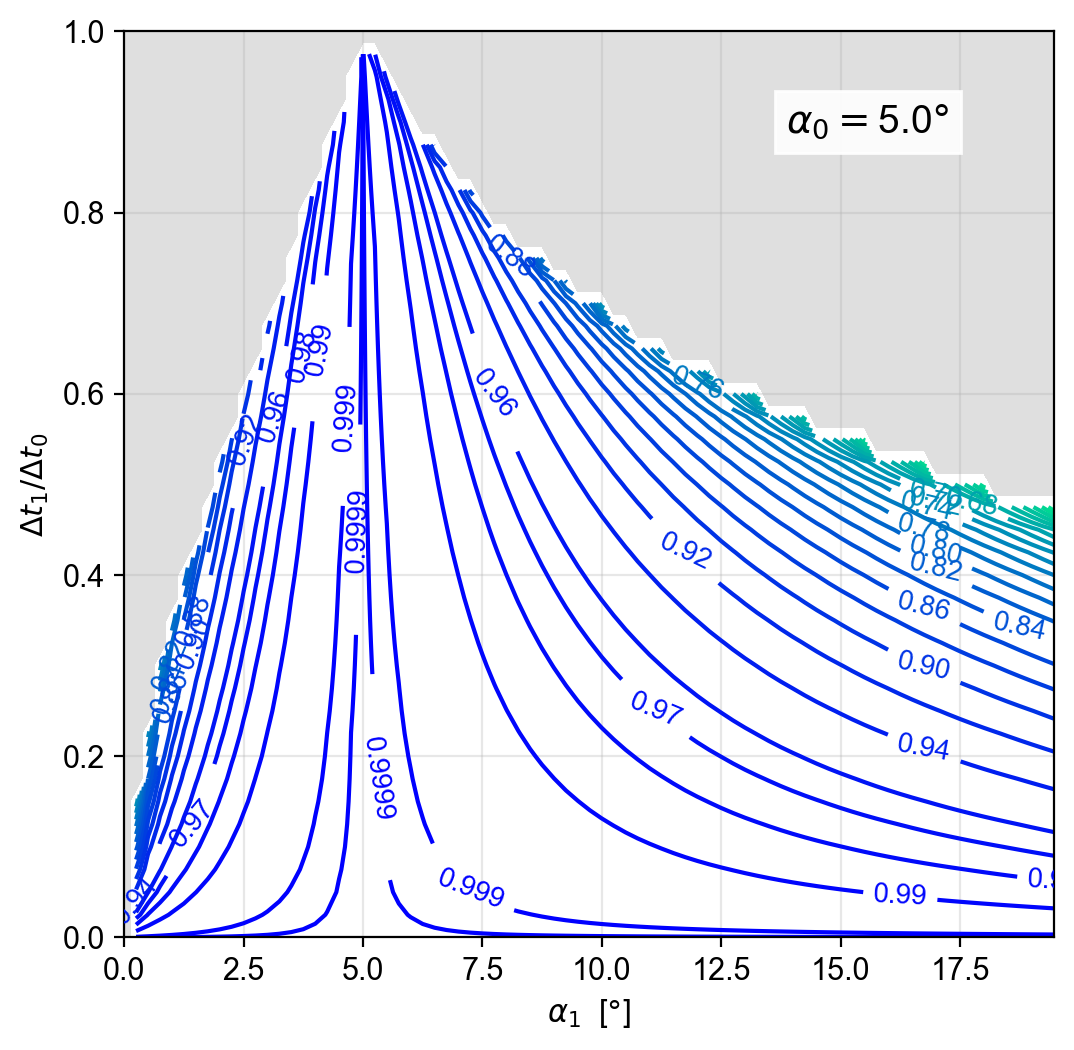

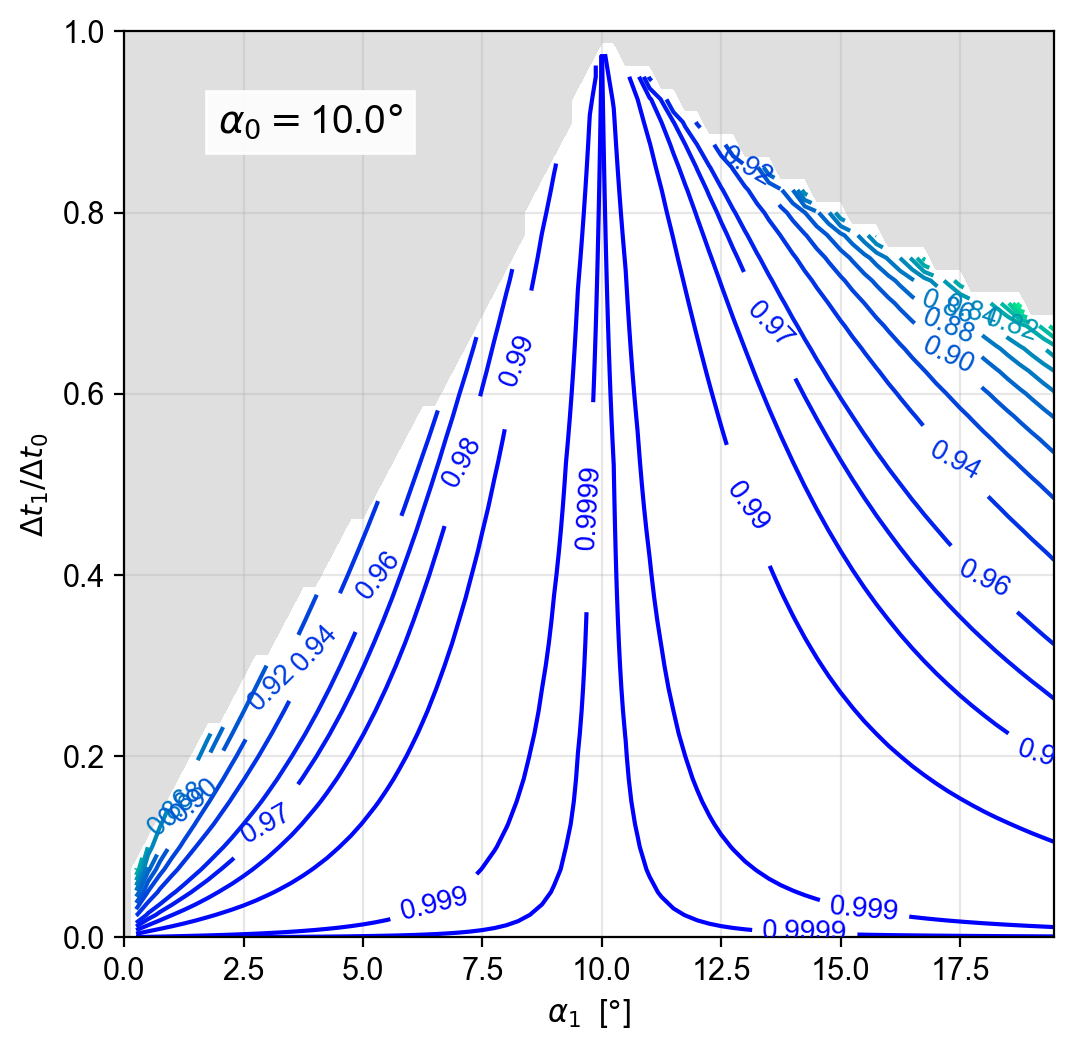

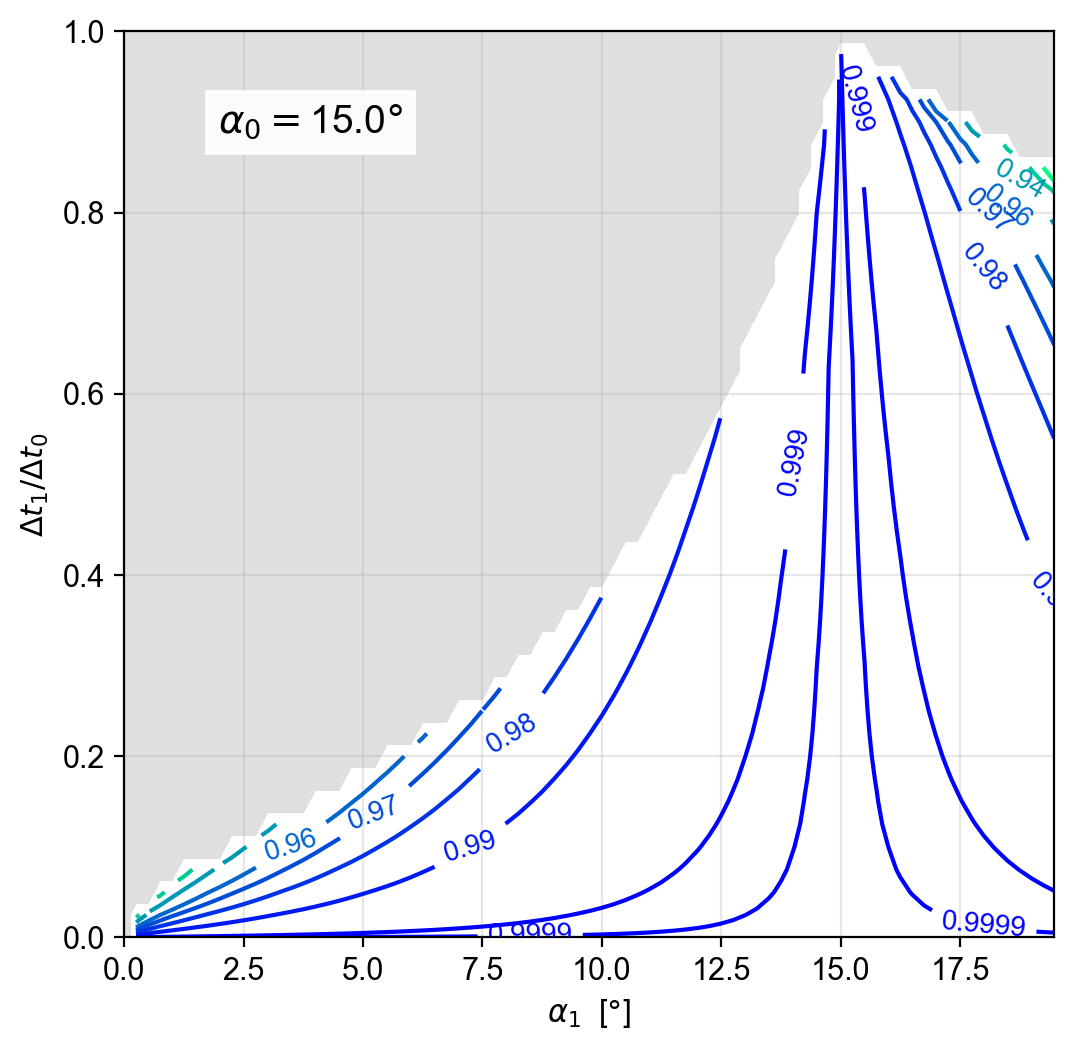

In [552]:
grt.contoured_delta_t12(
    job_name,
    alpha1_arrays,
    ndelta_t1_arrays,
    ndelta_t12_grids,
    alpha0_array,
    fig_size=(6, 6),
)

# Save

In [553]:
pp(gri.fdict)

{   'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar': <Figure size 600x600 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear': <Figure size 700x900 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom': <Figure size 700x700 with 1 Axes>}


In [554]:
pp(grt.fdict)

{   'indicatrix_exploration_sinbeta_eta0p5_falpha0p31': <Figure size 600x600 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_falpha0p56': <Figure size 600x600 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta0p5_falpha0p82': <Figure size 600x600 with 1 Axes>}


In [555]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gri.fdict, plots_dir, pr.save.figs_format, suffix='' )
export_plots( grt.fdict, plots_dir, pr.save.figs_format, suffix='' )

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear.pdf"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_rectlinear_zoom.pdf"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_Fstar_F_polar.pdf"
gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_falpha0p31.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_sinbeta_eta0p5_falpha0p56.jpg"
gmplib.save.export_plot: Exported "indicatrix_exploration_